In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.naive_bayes import CategoricalNB
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC


In [5]:
races = pd.read_csv('gdrive/My Drive/Varidhi_solanki_2024UCA1840/Dataset/New folder/races.csv', na_values='\\N')
results = pd.read_csv('gdrive/My Drive/Varidhi_solanki_2024UCA1840/Dataset/New folder/results.csv', na_values='\\N')
drivers = pd.read_csv('gdrive/My Drive/Varidhi_solanki_2024UCA1840/Dataset/New folder/drivers.csv', na_values='\\N')
constructors = pd.read_csv('gdrive/My Drive/Varidhi_solanki_2024UCA1840/Dataset/New folder/constructors.csv', na_values='\\N')
df = pd.merge(races, results, on='raceId')
df = pd.merge(df, drivers, on='driverId')
df = pd.merge(df, constructors, on='constructorId')

df['driver_name'] = df['forename'] + ' ' + df['surname']
relevant_columns = [
                    'raceId', 'year', 'round', 'circuitId', 'grid', 'position',
                    'points', 'laps', 'fastestLapSpeed', 'driverId','driver_name',
                    'constructorId'
                   ]

df = df[relevant_columns]
df.head()


,raceId,year,round,circuitId,grid,position,points,laps,fastestLapSpeed,driverId,driver_name,constructorId
0,1,2009,1,1,1,1.0,10.0,58,216.891,18,Jenson Button,23
1,1,2009,1,1,2,2.0,8.0,58,214.344,22,Rubens Barrichello,23
2,1,2009,1,1,20,3.0,6.0,58,214.706,15,Jarno Trulli,7
3,1,2009,1,1,19,4.0,5.0,58,215.920,10,Timo Glock,7
4,1,2009,1,1,10,5.0,4.0,58,215.199,4,Fernando Alonso,4


making dataframe

In [6]:
print(df.isnull().sum())
numerical_columns = df.select_dtypes(include=[np.number]).columns
df[numerical_columns] = df[numerical_columns].fillna(0)

categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns] = df[categorical_columns].fillna('no data')

duplicates_count = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates_count}")
df = df.drop_duplicates()


raceId                 0
year                   0
round                  0
circuitId              0
grid                   0
position           10928
points                 0
laps                   0
fastestLapSpeed    18499
driverId               0
driver_name            0
constructorId          0
dtype: int64

Number of duplicate rows: 0


cleaning data

In [7]:
df['podium'] = df['position'].apply(lambda x: 1 if x <= 3 else 0)
print (df.head())

   raceId  year  round  circuitId  grid  position  points  laps  \
0       1  2009      1          1     1       1.0    10.0    58   
1       1  2009      1          1     2       2.0     8.0    58   
2       1  2009      1          1    20       3.0     6.0    58   
3       1  2009      1          1    19       4.0     5.0    58   
4       1  2009      1          1    10       5.0     4.0    58   

   fastestLapSpeed  driverId         driver_name  constructorId  podium  
0          216.891        18       Jenson Button             23       1  
1          214.344        22  Rubens Barrichello             23       1  
2          214.706        15        Jarno Trulli              7       1  
3          215.920        10          Timo Glock              7       0  
4          215.199         4     Fernando Alonso              4       0  


created a column( which would be the target) which stores podium as true false val

215


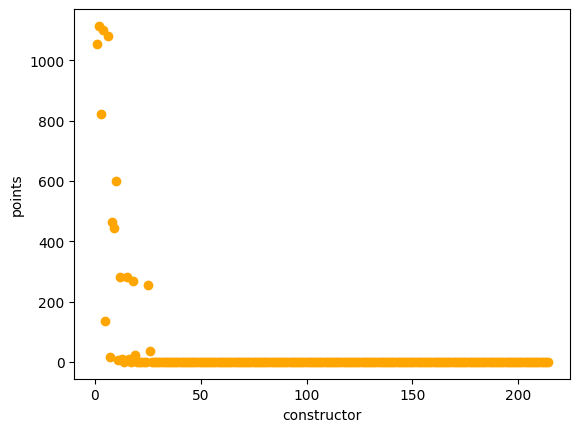

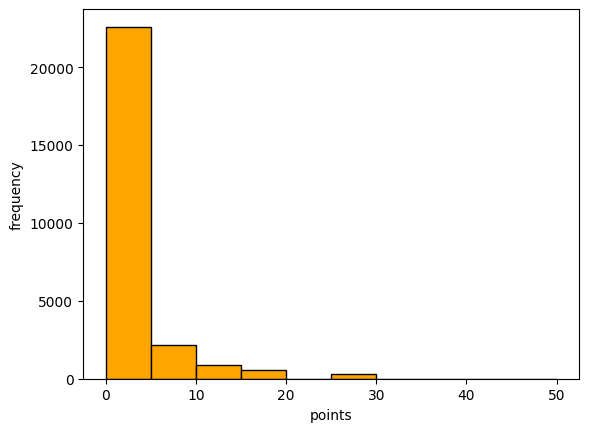

80


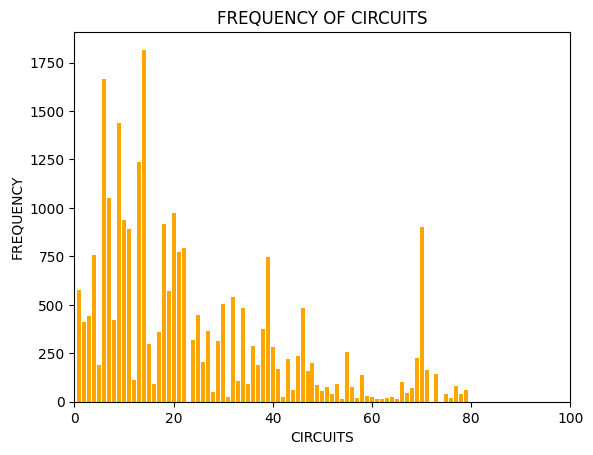

In [ ]:
maxval=constructors['constructorId'].max()
print(maxval)
pointfreq={}
for i in range(1,maxval):
  count = df['points'].value_counts().get(i, 0)
  pointfreq[i]=count
Constructor = list(pointfreq.keys())
Points = list(pointfreq.values())
plt.scatter(Constructor, Points,color='orange')
plt.xlabel("constructor")
plt.ylabel("points")
plt.show()

from matplotlib.pyplot import hist
hist(df.points,color='orange',edgecolor='black')
plt.xlabel("points")
plt.ylabel("frequency")
plt.show()

maxval=df['circuitId'].max()
print(maxval)
circuitfreq={}
for i in range(1,maxval):
  count = df['circuitId'].value_counts().get(i, 0)
  circuitfreq[i]=count

ident = list(circuitfreq.keys())
values = list(circuitfreq.values())
plt.bar(ident,values, color='orange')
plt.title('FREQUENCY OF CIRCUITS')
plt.xlabel('CIRCUITS')
plt.ylabel('FREQUENCY')
plt.xlim(0,100)
plt.show()

visualisation

     driverId  points
0           1  4713.5
19         20  3098.0
828       830  2744.5
3           4  2304.0
7           8  1873.0
       raceId  year  round  circuitId  grid  position  points  laps  \
4           1  2009      1          1    10       5.0     4.0    58   
12          1  2009      1          1     3      13.0     0.0    56   
14          1  2009      1          1     7      15.0     0.0    55   
19          1  2009      1          1    18       0.0     0.0    58   
26          2  2009      2          2    12       7.0     1.0    31   
...       ...   ...    ...        ...   ...       ...     ...   ...   
26483    1131  2024     11         70     1       5.0    10.0    71   
26496    1131  2024     11         70    15      18.0     0.0    70   
26499    1132  2024     12          9     2       1.0    25.0    52   
26500    1132  2024     12          9     4       2.0    18.0    52   
26506    1132  2024     12          9    10       8.0     4.0    52   

       fastestL

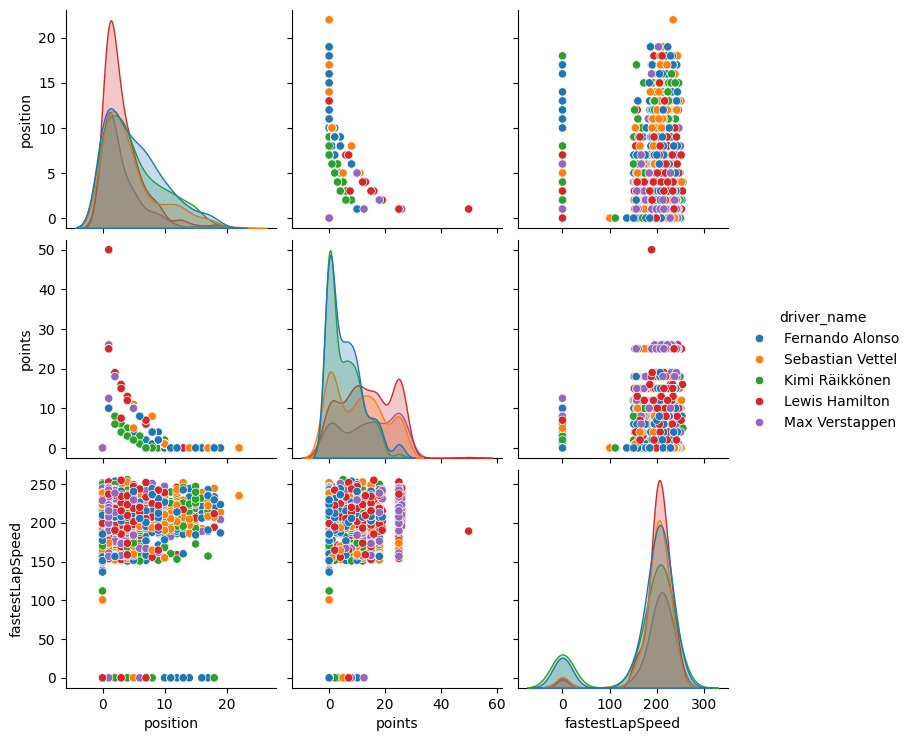

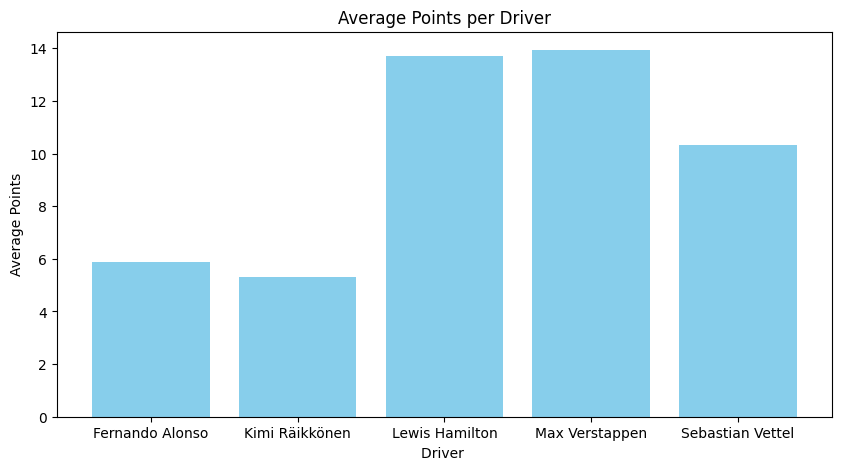

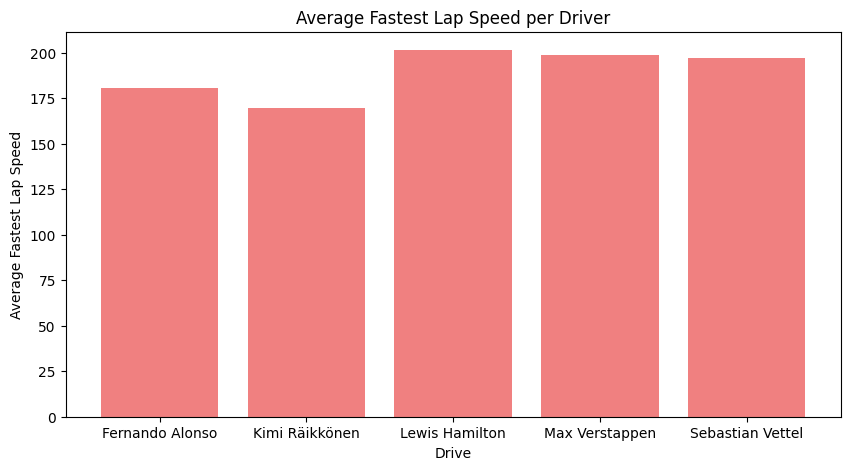

In [ ]:
cumulative_points = df.groupby('driverId', as_index=False)['points'].sum()
top_5_drivers = cumulative_points.nlargest(5, 'points')

print(top_5_drivers)
top_drivers_list = top_5_drivers['driverId'].tolist()
filtered_df = df[df['driverId'].isin(top_drivers_list)]

print(filtered_df)

sns.pairplot(filtered_df[['position','points','fastestLapSpeed','driver_name']], hue='driver_name')

avg_stats = filtered_df.groupby('driver_name').agg({
    'position': 'mean',
    'points': 'mean',
    'fastestLapSpeed': 'mean'
})

plt.figure(figsize=(10, 5))
plt.bar(avg_stats.index, avg_stats['points'], color='skyblue')
plt.xlabel('Driver ')
plt.ylabel('Average Points')
plt.title('Average Points per Driver')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(avg_stats.index, avg_stats['fastestLapSpeed'], color='lightcoral')
plt.xlabel('Drive')
plt.ylabel('Average Fastest Lap Speed')
plt.title('Average Fastest Lap Speed per Driver')
plt.show()

visualising data of the 5 drivers with most points

In [ ]:

required_columns = ['grid', 'position', 'points',
                   'laps', 'fastestLapSpeed', 'podium','driverId']

corr = df[required_columns].corr()
corr_matrix = corr.abs()
print(corr_matrix)

                     grid  position    points      laps  fastestLapSpeed  \
grid             1.000000  0.294399  0.374332  0.072784         0.033387   
position         0.294399  1.000000  0.134446  0.475819         0.382225   
points           0.374332  0.134446  1.000000  0.249624         0.350783   
laps             0.072784  0.475819  0.249624  1.000000         0.193855   
fastestLapSpeed  0.033387  0.382225  0.350783  0.193855         1.000000   
podium           0.217829  0.846162  0.094837  0.515575         0.316806   
driverId         0.054727  0.196177  0.043002  0.110063         0.285368   

                   podium  driverId  
grid             0.217829  0.054727  
position         0.846162  0.196177  
points           0.094837  0.043002  
laps             0.515575  0.110063  
fastestLapSpeed  0.316806  0.285368  
podium           1.000000  0.144706  
driverId         0.144706  1.000000  


In [10]:

features =['grid', 'round', 'fastestLapSpeed',]
x = df[features]
y = df['podium']

x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2,random_state=42)

scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)     #podium doesnt need to be transformes as it is in 0,1
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)            #all are numerical columns so need of encoding



this split the data and normalised it

In [13]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}

# Train and evaluate models
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy}")




Logistic Regression Accuracy: 0.6546003016591252
Random Forest Accuracy: 0.6572398190045249
SVM Accuracy: 0.6887254901960784


choosing svm as it has highest sccuracy

In [14]:
svn = SVC()
svn.fit(x_train, y_train)
predictions = svn.predict(x_test)
accuracy_score(y_test, predictions)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.78      0.44      0.57      2425
           1       0.66      0.89      0.76      2879

    accuracy                           0.69      5304
   macro avg       0.72      0.67      0.66      5304
weighted avg       0.71      0.69      0.67      5304

